In [1]:
import sys

from copy import copy
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import utils

import metrics

from random_MDPs.utils import (
    compute_planning_error,
    compute_planning_error_policy,
    get_normalized_matrix,
    get_normalized_matrix_policy,
)
from random_MDPs.metrics import (
    Lip, Lip_R
)


In [2]:
N=10
num_experiments=50
reward_type="structured"

In [3]:
def experiment(num_experiments, gamma, N, reward_type, policy=None, n_actions=1):
    li_TV, li_KL, li_W = [], [], []
    li_planning_error = []
    li_lip_T, li_lip_T_hat = [], []
    for experiment in range(num_experiments):
        np.random.seed(experiment)  # choose a seed for reproducability
        if policy is not None:
            T, T_hat = (
                get_normalized_matrix_policy(N, n_actions),
                get_normalized_matrix_policy(N, n_actions),
            )
        else:
            T, T_hat = get_normalized_matrix(N), get_normalized_matrix(N)

        if reward_type == "random":
            R = np.random.random(N).reshape(N, 1)
        elif reward_type == "structured":
            R = np.array([x for x in range(N)]).reshape(N, 1)
        else:
            print("undefined reward structure ...")
            sys.exit(1)

        if policy is not None:
            policy = np.random.randint(low=0, high=n_actions, size=(N, 1))
            planning_error = compute_planning_error_policy(
                T, T_hat, R, gamma, N, policy
            )
        else:
            planning_error = compute_planning_error(T, T_hat, R, gamma, N)

        li_planning_error.append(planning_error)
        (
            li_TV.append(metrics.TV(T.reshape((-1, N)), T_hat.reshape((-1, N)))),
            li_KL.append(metrics.KL(T.reshape((-1, N)), T_hat.reshape((-1, N)))),
            li_W.append(metrics.W(T.reshape((-1, N)), T_hat.reshape((-1, N)))),
        )

        # lipschitz cinstant of transition functions
        li_lip_T.append(metrics.Lip(T))
        li_lip_T_hat.append(metrics.Lip(T_hat))

    return li_TV, li_KL, li_W, li_planning_error, li_lip_T, li_lip_T_hat


In [6]:
W_correlation = []
TV_correlation = []
KL_correlation = []
gamma_li = [0.05 * x for x in range(15, 20)]

for gamma in gamma_li:
    print("running {} experiments for gamma={}".format(num_experiments, gamma))
    # run experiments and collect data
    li_TV, li_KL, li_W, li_planning_error, li_lip_T, li_lip_T_hat = experiment(
        num_experiments, gamma, N, reward_type, policy=True, n_actions=4
    )
    TV_correlation.append(
        utils.compute_covariance(li_TV, li_planning_error)
    )  # compute covariances...
    KL_correlation.append(utils.compute_covariance(li_KL, li_planning_error))  # ..
    W_correlation.append(utils.compute_covariance(li_W, li_planning_error))  # .

running 50 experiments for gamma=0.75
running 50 experiments for gamma=0.8
running 50 experiments for gamma=0.8500000000000001
running 50 experiments for gamma=0.9
running 50 experiments for gamma=0.9500000000000001


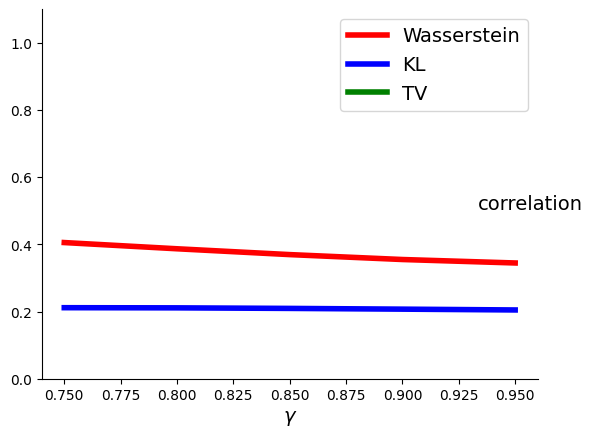

In [7]:
plt.plot(gamma_li, W_correlation, color="red", lw=4, label="Wasserstein")
plt.plot(gamma_li, KL_correlation, color="blue", lw=4, label="KL")
plt.plot(gamma_li, TV_correlation, color="green", lw=4, label="TV")
plt.ylabel("correlation", rotation=0, labelpad=-5, fontsize=14)
plt.ylim([0, 1.1])
plt.xlabel(r"$\gamma$", fontsize=14)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(fontsize=14)
plt.show()

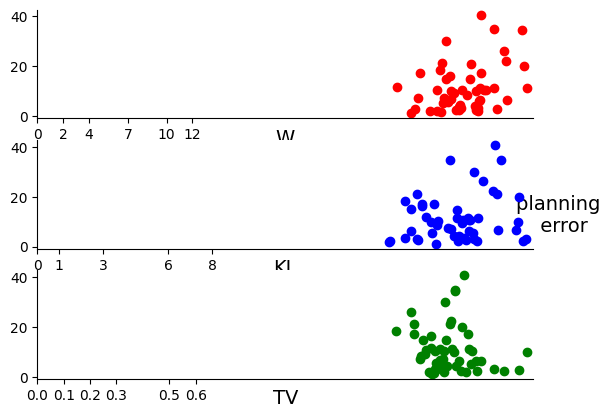

In [8]:
ax = plt.subplot(311)
plt.plot(li_W, li_planning_error, "o", color="red")
plt.xlabel("W", labelpad=-10, fontsize=14)
plt.xticks([0, 2, 4, 7, 10, 12])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax = plt.subplot(312)
plt.plot(li_KL, li_planning_error, "o", color="blue")
plt.xlabel("KL", labelpad=-10, fontsize=14)
ax.yaxis.set_label_position("right")
plt.xticks([0, 1, 3, 6, 8])
plt.ylabel("planning \n error", rotation=0, labelpad=20, fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax = plt.subplot(313)
plt.plot(li_TV, li_planning_error, "o", color="green")
plt.xlabel("TV", labelpad=-10, fontsize=14)
plt.xticks([0, 0.1, 0.2, 0.3, 0.5, 0.6])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

plt.show()

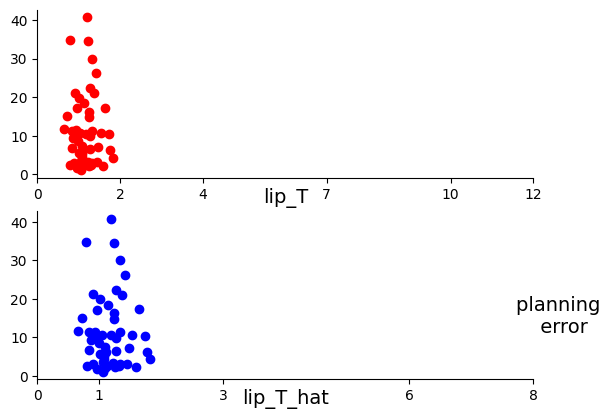

In [9]:
ax = plt.subplot(211)
plt.plot(li_lip_T, li_planning_error, "o", color="red")
plt.xlabel("lip_T", labelpad=-10, fontsize=14)
plt.xticks([0, 2, 4, 7, 10, 12])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax = plt.subplot(212)
plt.plot(li_lip_T_hat, li_planning_error, "o", color="blue")
plt.xlabel("lip_T_hat", labelpad=-10, fontsize=14)
ax.yaxis.set_label_position("right")
plt.xticks([0, 1, 3, 6, 8])
plt.ylabel("planning \n error", rotation=0, labelpad=20, fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

plt.show()


## Perturbation on the true transition probability

for a small perturbation sigma=0.0001: TV=0.0018946160130015855|KL=0.00010608053981790712|W=0.042089772994383885


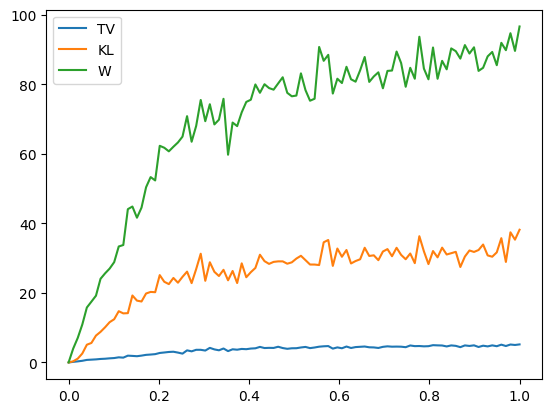

In [37]:
N = 10
n_actions = 4
gamma = 0.5
P_true = get_normalized_matrix_policy(N, n_actions)

# li_TV.append(metrics.TV(T.reshape((-1, N)), T_hat.reshape((-1, N)))),
# li_KL.append(metrics.KL(T.reshape((-1, N)), T_hat.reshape((-1, N)))),
# li_W.append(metrics.W(T.reshape((-1, N)), T_hat.reshape((-1, N)))),

TV_sigma = []
KL_sigma = []
W_sigma = []

sigmas = np.linspace(0.0001, 1.0, 100)

for sigma in sigmas:
    noise = np.random.normal(loc=0.0, scale=sigma, size=P_true.shape)
    P_perturbed = np.abs(P_true.copy() + noise)
    for i in range(N):
        for action in range(n_actions):
            P_perturbed[i, action, :] = P_perturbed[i, action, :] / np.sum(
                P_perturbed[i, action, :]
            )
    TV_sigma.append(metrics.TV(P_true.reshape((-1, N)), P_perturbed.reshape((-1, N))))
    KL_sigma.append(metrics.KL(P_true.reshape((-1, N)), P_perturbed.reshape((-1, N))))
    W_sigma.append(metrics.W(P_true.reshape((-1, N)), P_perturbed.reshape((-1, N))))

print(
    f"for a small perturbation sigma={sigmas[0]}: TV={TV_sigma[0]}|KL={KL_sigma[0]}|W={W_sigma[0]}"
)

plt.figure()
plt.plot(sigmas, TV_sigma, label="TV")
plt.plot(sigmas, KL_sigma, label="KL")
plt.plot(sigmas, W_sigma, label="W")
plt.legend()
plt.show()


### For a random policy and reward function: we can compute the value gap

In [4]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    value_function = np.zeros(Ns)
    # ====================================================
	# YOUR IMPLEMENTATION HERE 
    #
    Rs = [R[i,policy[i]] for i in range(Ns)]
    gammaP = [[gamma*P[i,policy[i],j] for j in range(Ns)] for i in range(Ns)]
    value_function = np.linalg.solve(np.identity(int(Ns)) - gammaP,Rs)
    # ====================================================
    return value_function

def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.zeros(Ns, dtype="int")
    # ====================================================
	# YOUR IMPLEMENTATION HERE 
    #
    cond = True
    iteration = 0
    while cond:
        Vk = policy_evaluation(P, R, policy, gamma, 1e-2)
        for s in range(Ns):
            act = np.zeros(Na)
            for a in range(Na):
                inter = 0
                for sprime in range (Ns):
                    inter += gamma*Vk[sprime]*P[s,a,sprime]
                act[a] = inter
            vector = R[s,:] + act
            policy[s] = np.argmax(vector) 
        if np.linalg.norm(Vk - V) < tol:    
            cond = False
        V = Vk
        iteration += 1
    V = policy_evaluation(P, R, policy, gamma, 1e-2)
    # ====================================================
    return policy, V, iteration

def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
    # YOUR IMPLEMENTATION HERE 
    #
    cond = True
    iteration = 0
    while cond:
        Qnew = np.zeros((Ns, Na))
        Qmax = np.max(Q,axis=1)
        Qnew = np.tensordot(P,Qmax,axes=1) 
        Qnew = R + gamma * Qnew
        Qfs.append(Qnew)
        if np.linalg.norm(Qnew - Q, ord=np.inf) <= tol:
            cond = False
        Q = Qnew
        iteration += 1
    greedy_policy = np.argmax(Q, axis=1)
    # ====================================================
    return Q, greedy_policy, Qfs, iteration

In [5]:
from abc import ABC, abstractmethod
from gym import utils


class FiniteEnv(ABC):
    """
    Base class for a finite MDP.

    Args:
        states      (list): List of legnth S containing the indexes of the states, e.g. [0,1,2]
        action_sets (list): List containing the actions available in each state, e.g. [[0,1], [2,3]],
                            action_sets[i][j] returns the index of the j-th available action in state i
        P       (np.array): Array of shape (Ns, Na, Ns) containing the transition probabilities,
                            P[s, a, s'] = Prob(S_{t+1}=s'| S_t = s, A_t = a). Na is the total number of actions.
        gamma      (float): discount factor


    Attributes:
        Ns   (int): Number of states
        Na   (int): Number of actions
        actions (list): list containing all possible actions = [0, 1, ..., Na-1]

    """
    def __init__(self, states, action_sets, P, gamma):

        self.states = states
        self.action_sets = action_sets
        self.actions = list(set().union(*action_sets))
        self.Ns = len(states)
        self.Na = len(self.actions)
        self.P = P

        self.state = 0  # initial state
        self.gamma = gamma
        self.reset()
        super().__init__()

    def available_actions(self, state=None):
        """
        Return all actions available in a given state.
        """
        if state is not None:
            return self.action_sets[state]
        return self.action_sets[self.state]

    @abstractmethod
    def reset(self):
        """
        Reset the environment to a default state.

        Returns:
            state (object)
        """
        pass

    @abstractmethod
    def reward_func(self, state, action, next_state):
        """
        Args:
            state      (int): current state
            action     (int): current action
            next_state (int): next state

        Returns:
            reward (float)
        """
        pass

    @abstractmethod
    def step(self, action):
        """
        Execute a step. Similar to gym function [1].
        [1] https://gym.openai.com/docs/#environments

        Args:
            action (int): index of the action to take

        Returns:
            observation (object)
            reward      (float)
            done        (bool)
            info        (dict)
        """
        pass

    @abstractmethod
    def sample_transition(self, s, a):
        """
        Sample a transition s' from P(s'|s,a).

        Args:
            s (int): index of state
            a (int): index of action

        Returns:
            ss (int): index of next state
        """
        pass

class GridWorldWithPits(FiniteEnv):
    def __init__(self, grid, txt_map, gamma=0.99, proba_succ=0.95, uniform_trans_proba=0.001, normalize_reward=False):
        self.desc = np.asarray(txt_map, dtype='c')
        self.grid = grid
        self.txt_map = txt_map

        self.action_names = np.array(['right', 'down', 'left', 'up'])

        self.n_rows, self.n_cols = len(self.grid), max(map(len, self.grid))

        # Create a map to translate coordinates [r,c] to scalar index
        # (i.e., state) and vice-versa
        self.normalize_reward = normalize_reward


        self.initial_state = None
        self.coord2state = np.empty_like(self.grid, dtype="int")
        self.nb_states = 0
        self.state2coord = []
        for i in range(self.n_rows):
            for j in range(len(self.grid[i])):
                if self.grid[i][j] != 'w':
                    if self.grid[i][j] == 's':
                        self.initial_state = self.nb_states
                    self.coord2state[i, j] = self.nb_states
                    self.nb_states += 1
                    self.state2coord.append([i, j])
                else:
                    self.coord2state[i, j] = -1

        self.P = None
        self.R = None
        self.proba_succ = proba_succ
        self.uniform_trans_proba = uniform_trans_proba

        # compute the actions available in each state
        self.state_actions = [range(len(self.action_names)) for _ in range(self.nb_states)]#self.compute_available_actions()
        self.matrix_representation()
        self.lastaction = None
        super(GridWorldWithPits, self).__init__(states=range(self.nb_states), action_sets=self.state_actions, P=self.P, gamma=gamma)
        self.current_step = 0

    def matrix_representation(self):
        if self.P is None:
            nstates = self.nb_states
            nactions = max(map(len, self.state_actions))
            self.P = np.inf * np.ones((nstates, nactions, nstates))
            self.R = np.inf * np.ones((nstates, nactions))
            for s in range(nstates):
                r, c = self.state2coord[s]
                for a_idx, action in enumerate(range(len(self.action_names))):
                    self.P[s, a_idx].fill(0.)
                    if self.grid[r][c] == 'g':
                        self.P[s, a_idx, self.initial_state] = 1.
                        self.R[s, a_idx] = 10.
                    else:
                        ns_succ, ns_fail = np.inf, np.inf
                        if action == 0:
                            ns_succ = self.coord2state[r, min(self.n_cols - 1, c + 1)]
                            ns_fail = [self.coord2state[r, max(0, c - 1)],
                            self.coord2state[min(self.n_rows - 1, r + 1), c],
                            self.coord2state[max(0, r - 1), c]
                            ]

                        elif action == 1:
                            ns_succ = self.coord2state[min(self.n_rows - 1, r + 1), c]
                            ns_fail = [self.coord2state[max(0, r - 1), c],
                            self.coord2state[r, max(0, c - 1)],
                            self.coord2state[r, min(self.n_cols - 1, c + 1)]
                            ]
                        elif action == 2:
                            ns_succ = self.coord2state[r, max(0, c - 1)]
                            ns_fail = [self.coord2state[r, min(self.n_cols - 1, c + 1)],
                            self.coord2state[max(0, r - 1), c],
                            self.coord2state[min(self.n_rows - 1, r + 1), c]
                            ]
                        elif action == 3:
                            ns_succ = self.coord2state[max(0, r - 1), c]
                            ns_fail = [self.coord2state[min(self.n_rows - 1, r + 1), c],
                            self.coord2state[r, min(self.n_cols - 1, c + 1)],
                            self.coord2state[r, max(0, c - 1)]
                            ]

                        L = []
                        for el in ns_fail:
                            x, y = self.state2coord[el]
                            if self.grid[x][y] == 'w':
                                L.append(s)
                            else:
                                L.append(el)

                        self.P[s, a_idx, ns_succ] = self.proba_succ
                        for el in L:
                            self.P[s, a_idx, el] += (1. - self.proba_succ)/len(ns_fail)
                        # self.P[s, a_idx] = self.P[s, a_idx] + self.uniform_trans_proba / nstates
                        # self.P[s, a_idx] = self.P[s, a_idx] / np.sum(self.P[s, a_idx])

                        assert np.isclose(self.P[s, a_idx].sum(), 1)

                        if self.grid[r][c] == 'x':
                            self.R[s, a_idx] = -20
                        else:
                            self.R[s, a_idx] = -2

            if self.normalize_reward:
                minr = np.min(self.R)
                maxr = np.max(self.R[np.isfinite(self.R)])
                self.R = (self.R - minr) / (maxr - minr)

            self.d0 = np.zeros((nstates,))
            self.d0[self.initial_state] = 1.

    def compute_available_actions(self):
        # define available actions in each state
        # actions are indexed by: 0=right, 1=down, 2=left, 3=up
        state_actions = []
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                if self.grid[i][j] == 'g':
                    state_actions.append([0])
                elif self.grid[i][j] != 'w':
                    actions = [0, 1, 2, 3]
                    if i == 0:
                        actions.remove(3)
                    if j == self.n_cols - 1:
                        actions.remove(0)
                    if i == self.n_rows - 1:
                        actions.remove(1)
                    if j == 0:
                        actions.remove(2)

                    for a in copy.copy(actions):
                        r, c = i, j
                        if a == 0:
                            c = min(self.n_cols - 1, c + 1)
                        elif a == 1:
                            r = min(self.n_rows - 1, r + 1)
                        elif a == 2:
                            c = max(0, c - 1)
                        else:
                            r = max(0, r - 1)
                        if self.grid[r][c] == 'w':
                            actions.remove(a)

                    state_actions.append(actions)
        return state_actions

    def description(self):
        desc = {
            'name': type(self).__name__
        }
        return desc

    def reward_func(self, state, action, next_state):
        return self.R[state, action]

    def reset(self, s=None):
        self.lastaction = None
        if s is None:
            self.state = self.initial_state
        else:
            self.state = s
        self.current_step = 0
        return self.state

    def step(self, action):
        try:
            action_index = self.state_actions[self.state].index(action)
        except:
            raise ValueError("Action {} cannot be executed in this state {}".format(action, self.state))

        p = self.P[self.state, action_index]
        next_state = np.random.choice(self.nb_states, 1, p=p).item()

        reward = self.R[self.state, action_index]

        self.lastaction = action

        r, c = self.state2coord[self.state]
        done = self.grid[r][c] == 'g'
        self.current_step +=1
        self.state = next_state

        return next_state, reward, done, {}

    def render(self):
        outfile = sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        r, c = self.state2coord[self.state]

        def ul(x):
            return "_" if x == " " else x

        if self.grid[r][c] == 'x':
            out[1 + r][2 * c + 1] = utils.colorize(out[1 + r][2 * c + 1], 'red', highlight=True)
        elif self.grid[r][c] == 'g':  # passenger in taxi
            out[1 + r][2 * c + 1] = utils.colorize(ul(out[1 + r][2 * c + 1]), 'green', highlight=True)
        else:
            out[1 + r][2 * c + 1] = utils.colorize(ul(out[1 + r][2 * c + 1]), 'yellow', highlight=True)

        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(self.action_names[self.lastaction]))
        else:
            outfile.write("\n")
        outfile.flush()

    def render_policy(self, pol):
        outfile = sys.stdout
        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        r, c = self.state2coord[self.state]

        for s in range(self.Ns):
            r, c = self.state2coord[s]
            action = pol[s]
            # 'right', 'down', 'left', 'up'
            if action == 0:
                out[1 + r][2 * c + 1] = '>'
            elif action == 1:
                out[1 + r][2 * c + 1] = 'v'
            elif action == 2:
                out[1 + r][2 * c + 1] = '<'
            elif action == 3:
                out[1 + r][2 * c + 1] = '^'
            else:
                raise ValueError()

        outfile.write("\n".join(["".join(row) for row in out]) + "\n")

    def copy(self):
        new_env = GridWorldWithPits(grid=self.grid, txt_map=self.txt_map,
                                    proba_succ=self.proba_succ, uniform_trans_proba=self.uniform_trans_proba)
        return new_env

    def sample_transition(self, s, a):
        try:
            p = self.P[s, a]
        except:
            raise ValueError("Action {} cannot be executed in this state {}".format(action, self.state))
        next_state = np.random.choice(self.nb_states, 1, p=p).item()


class CliffWalk(GridWorldWithPits):

    def __init__(self, proba_succ=0.95):
        grid1 = [
            ['', '', '', '', '', '', '', '', '', '', '', '',],
            ['', '', '', '', '', '', '', '', '', '', '', '',],
            ['', '', '', '', '', '', '', '', '', '', '', '',],
            ['s', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'g']
        ]
        grid1_MAP = [
            "+-----------------------+",
            "| : : : : : : : : : : : |",
            "| : : : : : : : : : : : |",
            "| : : : : : : : : : : : |",
            "|S:x:x:x:x:x:x:x:x:x:x:G|",
            "+-----------------------+",
        ]
        super(CliffWalk, self).__init__(grid=grid1, txt_map=grid1_MAP, proba_succ=proba_succ, uniform_trans_proba=0)

  3%|▎         | 3/100 [00:00<00:09, 10.71it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


  5%|▌         | 5/100 [00:00<00:09, 10.54it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


  9%|▉         | 9/100 [00:00<00:08, 10.65it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 11%|█         | 11/100 [00:01<00:08, 10.58it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 13%|█▎        | 13/100 [00:01<00:08, 10.55it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter


 17%|█▋        | 17/100 [00:01<00:08, 10.21it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 19%|█▉        | 19/100 [00:01<00:08, 10.09it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 21%|██        | 21/100 [00:02<00:07, 10.13it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 25%|██▌       | 25/100 [00:02<00:07,  9.43it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter


 28%|██▊       | 28/100 [00:02<00:07,  9.48it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 30%|███       | 30/100 [00:02<00:07,  9.93it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 32%|███▏      | 32/100 [00:03<00:06, 10.29it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 36%|███▌      | 36/100 [00:03<00:06, 10.44it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 38%|███▊      | 38/100 [00:03<00:05, 10.75it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 42%|████▏     | 42/100 [00:04<00:05, 10.59it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 46%|████▌     | 46/100 [00:04<00:05, 10.78it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 48%|████▊     | 48/100 [00:04<00:04, 11.16it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 50%|█████     | 50/100 [00:04<00:04, 11.42it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 54%|█████▍    | 54/100 [00:05<00:04, 10.50it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 56%|█████▌    | 56/100 [00:05<00:04, 10.69it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 60%|██████    | 60/100 [00:05<00:03, 10.66it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 64%|██████▍   | 64/100 [00:06<00:03, 10.97it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 66%|██████▌   | 66/100 [00:06<00:03, 10.97it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 70%|███████   | 70/100 [00:06<00:02, 11.33it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 72%|███████▏  | 72/100 [00:06<00:02, 11.03it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 74%|███████▍  | 74/100 [00:07<00:02, 10.38it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter


 76%|███████▌  | 76/100 [00:07<00:02,  9.61it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 80%|████████  | 80/100 [00:07<00:01, 10.10it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 84%|████████▍ | 84/100 [00:08<00:01, 10.54it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 86%|████████▌ | 86/100 [00:08<00:01, 10.64it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 90%|█████████ | 90/100 [00:08<00:00, 10.36it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 92%|█████████▏| 92/100 [00:08<00:00, 10.50it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 94%|█████████▍| 94/100 [00:08<00:00, 10.89it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


 98%|█████████▊| 98/100 [00:09<00:00, 10.47it/s]

policy iteration converged after 20 iter
policy iteration converged after 20 iter
policy iteration converged after 20 iter


100%|██████████| 100/100 [00:09<00:00, 10.48it/s]

policy iteration converged after 20 iter
for a small perturbation sigma=0.0001: value_gap=2.0268098660958245e-05
Lip P true: 1.1623528053697838
Lip R true: 0.8323738177898486


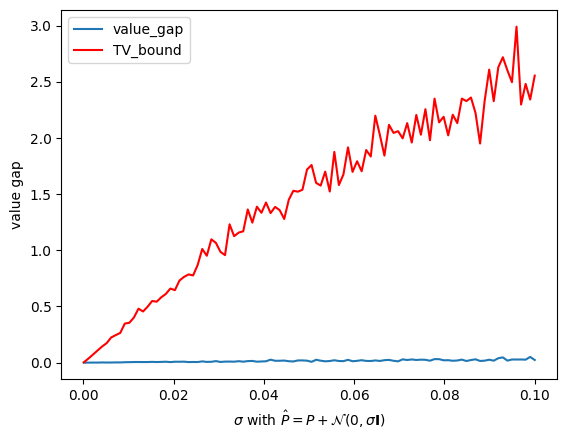

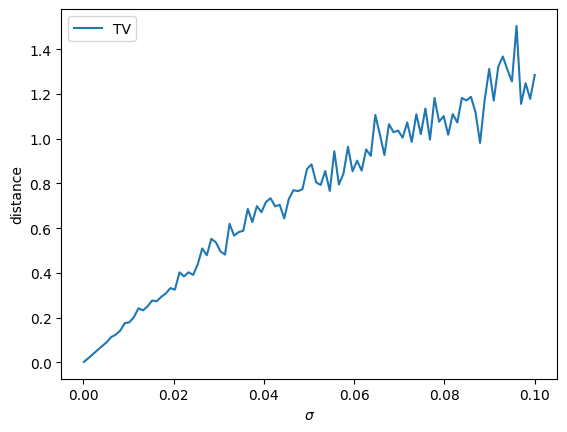

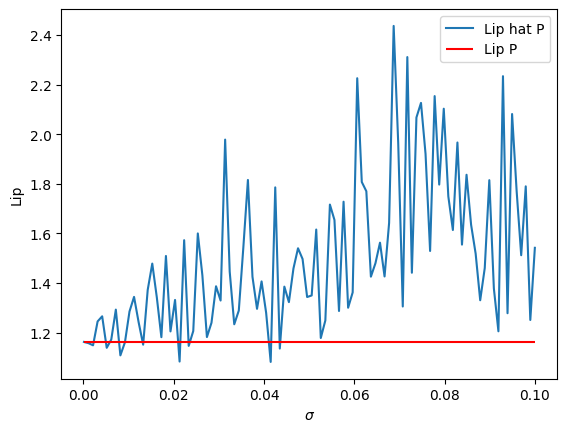

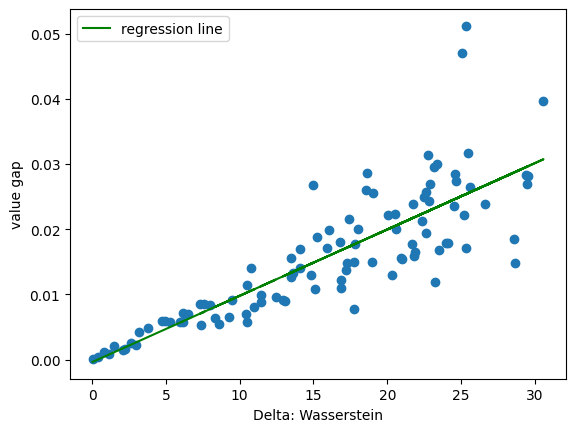

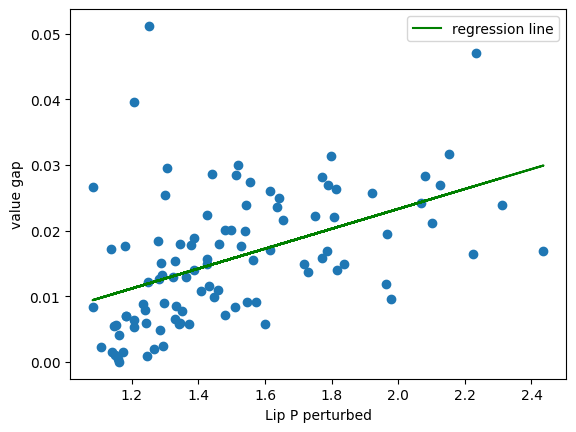

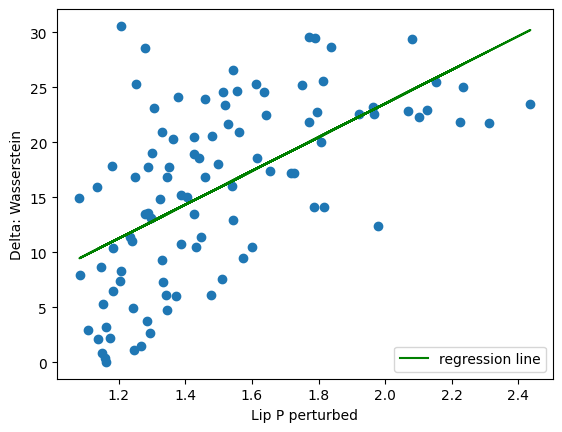

In [7]:
N = 10
n_actions = 4

gamma = 0.5
P_true = get_normalized_matrix_policy(N, n_actions)
R = np.random.random(size=(N, n_actions))
# R = np.array([x for x in range(N)]).reshape(N, 1)

tol = 1e-5

# proba_succ = 0.5
# env = CliffWalk(proba_succ)
# P_true = env.P
# R = env.R
# gamma = 0.5  # env.gamma
# N, n_actions, _ = env.P.shape

TV_sigma = []
KL_sigma = []
W_sigma = []
value_gap = []
lip_model = []


def compute_value_gap(T, T_hat, R, gamma, N, policy):
    I = np.identity(N)
    T_pi = np.array([[T[i, policy[i], j].item() for j in range(N)] for i in range(N)])
    T_hat_pi = np.array(
        [[T_hat[i, policy[i], j].item() for j in range(N)] for i in range(N)]
    )
    R = np.array([R[i, policy[i]] for i in range(N)])
    V = np.linalg.inv(I - gamma * T_pi).dot(R)
    V_hat = np.linalg.inv(I - gamma * T_hat_pi).dot(R)
    error = np.linalg.norm(V - V_hat, ord=np.inf)
    return error, V, V_hat


def compute_optimal_policy(T, R, gamma, algo='VI'):
    if algo == 'VI':
        _, policy, _, iteration = value_iteration(P=T, R=R, gamma=gamma, tol=tol)
    elif algo == 'PI':
        policy, _, iteration = policy_iteration(P=T, R=R, gamma=gamma, tol=tol)
    else:
        raise ValueError('algo not supported!')
    return policy, iteration


sigmas = np.linspace(0.0001, 0.1, 100)
for sigma in tqdm(sigmas):
    noise = np.random.normal(loc=0.0, scale=sigma, size=P_true.shape)
    P_perturbed = np.abs(P_true.copy() + noise)
    # print(f"P_true - P_perturbed = {np.linalg.norm(P_true-P_perturbed)}")
    for i in range(N):
        for action in range(n_actions):
            P_perturbed[i, action, :] = P_perturbed[i, action, :] / np.sum(
                P_perturbed[i, action, :]
            )

    TV_sigma.append(
        metrics.TV(copy(P_true).reshape((-1, N)), copy(P_perturbed).reshape((-1, N)))
    )
    KL_sigma.append(
        metrics.KL(copy(P_true).reshape((-1, N)), copy(P_perturbed).reshape((-1, N)))
    )
    W_sigma.append(
        metrics.W(copy(P_true).reshape((-1, N)), copy(P_perturbed).reshape((-1, N)))
    )

    policy, iteration = compute_optimal_policy(P_perturbed, R, gamma)
    print(f"policy iteration converged after {iteration} iter")

    planning_error, V, V_hat = compute_value_gap(
        P_true, P_perturbed, R, gamma, N, policy
    )

    value_gap.append(planning_error)

    lip_model.append(Lip(P_perturbed))

print(f"for a small perturbation sigma={sigmas[0]}: value_gap={value_gap[0]}")

Lip_P_true = Lip(P_true)
Lip_R_true = Lip_R(R.flatten())

print(f"Lip P true: {Lip_P_true}")
print(f"Lip R true: {Lip_R_true}")

def compute_th_bound(Delta, gamma, Lip_Reward, Lip_P_true, Lip_model, K='min'):
    # compute theoretical bound
    th_bound = np.array(Delta)  # Delta
    th_bound *= gamma  # gamma * Delta
    th_bound *= Lip_Reward  # gamma * K_R * Delta
    th_bound /= 1 - gamma  # gamma * K_R * Delta / (1 - gamma)
    # [gamma * K_R * Delta] / [(1 - gamma) * (1 - gamma * min(K_F,K_T))]
    if K == 'min':
        th_bound /= 1 - gamma * np.array(
            [min(Lip_P_true, Lip_model[i]) for i in range(len(Lip_model))]
        )  
    elif K == 'true':
        th_bound /= (1 - gamma * Lip_P_true)
    elif K == 'model':
        th_bound /= (1 - gamma * np.array(Lip_model))
    else:
        pass
    return np.abs(th_bound)

K = 'min'
TV_bound = compute_th_bound(
    Delta=TV_sigma, 
    gamma=gamma, 
    Lip_Reward=Lip_R_true, 
    Lip_P_true=Lip_P_true, 
    Lip_model=lip_model,
    K=K
)
KL_bound = compute_th_bound(
    Delta=KL_sigma, 
    gamma=gamma, 
    Lip_Reward=Lip_R_true, 
    Lip_P_true=Lip_P_true, 
    Lip_model=lip_model,
    K=K
)
W_bound = compute_th_bound(
    Delta=W_sigma, 
    gamma=gamma, 
    Lip_Reward=Lip_R_true, 
    Lip_P_true=Lip_P_true, 
    Lip_model=lip_model,
    K=K
)

plt.figure()
plt.plot(sigmas, value_gap, label="value_gap")
plt.plot(sigmas, TV_bound, label="TV_bound", color="red")
# plt.plot(sigmas, KL_bound, label="KL_bound", color="green")
# plt.plot(sigmas, W_bound, label="W_bound", color="purple")
plt.xlabel(r"$\sigma$ with $\hat{P} = P + \mathcal{N}(0,\sigma \mathbf{I})$")
plt.ylabel("value gap")
plt.legend()

plt.figure()
plt.plot(sigmas, TV_sigma, label="TV")
# plt.plot(sigmas, KL_sigma, label="KL")
# plt.plot(sigmas, W_sigma, label="W")
plt.xlabel(r"$\sigma$")
plt.ylabel("distance")
plt.legend()

plt.figure()
plt.plot(sigmas, lip_model, label="Lip hat P")
plt.hlines(y=Lip_P_true, xmin=sigmas[0], xmax=sigmas[-1], label="Lip P", color="red")
plt.xlabel(r"$\sigma$")
plt.ylabel("Lip")
plt.legend()

plt.figure()
plt.scatter(W_sigma, value_gap)
m, b = np.polyfit(W_sigma, value_gap, 1)
plt.plot(W_sigma, m * np.array(W_sigma) + b, label="regression line", color="green")
plt.xlabel("Delta: Wasserstein")
plt.ylabel("value gap")
plt.legend()

plt.figure()
plt.scatter(lip_model, value_gap)
m, b = np.polyfit(lip_model, value_gap, 1)
plt.plot(lip_model, m * np.array(lip_model) + b, label="regression line", color="green")
plt.xlabel("Lip P perturbed")
plt.ylabel("value gap")
plt.legend()

plt.figure()
plt.scatter(lip_model, W_sigma)
m, b = np.polyfit(lip_model, W_sigma, 1)
plt.plot(lip_model, m * np.array(lip_model) + b, label="regression line", color="green")
plt.xlabel("Lip P perturbed")
plt.ylabel("Delta: Wasserstein")
plt.legend()

plt.show()


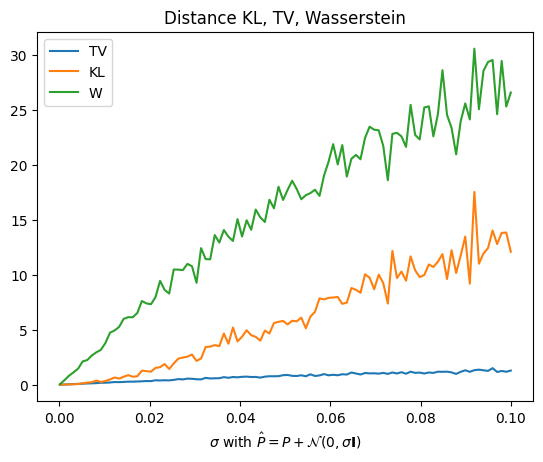

: 

In [12]:
plt.figure()
plt.plot(sigmas, TV_sigma, label="TV")
plt.plot(sigmas, KL_sigma, label="KL")
plt.plot(sigmas, W_sigma, label="W")
plt.xlabel(r"$\sigma$ with $\hat{P} = P + \mathcal{N}(0,\sigma \mathbf{I})$")
plt.title(r"Distance KL, TV, Wasserstein")
plt.legend()
plt.show()